In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Carregar os dados
df = pd.read_csv('dados/stocks.csv')

# Filtrar as datas de interesse (2017-02-24 até hoje)
start_date = '2017-02-24'
df['Date'] = pd.to_datetime(df['Date'])
filtered_df = df[df['Date'] >= start_date]

In [3]:
# Calcular as estatísticas relevantes
def calculate_ticker_stats(df):
    # Calcular retornos diários
    df['Return'] = df.groupby('ticker')['Close'].pct_change()

    # Definindo uma taxa livre de risco anual
    annual_risk_free_rate = 0.0729  # 7,29% foi a média anual aproximada de 100% do CDI nos últimos 7 anos

    # Calcular o número de anos nos dados para anualizar os retornos diários
    num_years = (df['Date'].max() - df['Date'].min()).days / 365.25

    # Agrupando por 'ticker' e calculando as métricas necessárias
    ticker_stats = df.groupby('ticker').agg(
        avg_return=('Return', lambda x: (1 + x).prod() ** (1 / num_years) - 1),  # retorno médio anualizado
        volatility=('Return', 'std'),  # desvio padrão dos retornos
        cumulative_return=('Return', lambda x: (1 + x).prod() - 1),  # retorno acumulado
        sharpe_ratio=('Return', lambda x: ((x.mean() * 252 - annual_risk_free_rate) /
                                           (x.std() * (252 ** 0.5))) if x.std() != 0 else None)
        # Sharpe ratio anualizado, considerando 252 dias de negociação por ano
    ).reset_index()

    return ticker_stats

In [4]:
def calculate_rvi(avg_return, volatility, sharpe_ratio, alpha, beta, gamma):
    return alpha * avg_return + beta * volatility + gamma * sharpe_ratio


# Pesos para o modelo de decisão
weights = {
    'Conservador': {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.1},
    'Moderado': {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.8},
    'Arrojado': {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.1}
}

def apply_profiles(ticker_stats, weights):
    rvi_scores = {}
    for profile, params in weights.items():
        rvi_scores[profile] = ticker_stats.apply(
            lambda row: calculate_rvi(row['avg_return'], row['volatility'], row['sharpe_ratio'], 
                                      params['alpha'], params['beta'], params['gamma']),
            axis=1
        )
    return rvi_scores

# Calcular as estatísticas dos tickers
ticker_stats = calculate_ticker_stats(filtered_df)

# Aplicar os perfis de investimento
rvi_scores = apply_profiles(ticker_stats, weights)

# Adicionar os scores ao dataframe de estatísticas dos tickers
for profile, score in rvi_scores.items():
    ticker_stats[f'rvi_{profile}'] = score

In [6]:
df_rvi = pd.DataFrame(ticker_stats)

# Função para aplicar coloração condicional
def color_negative_red(value):
    color = 'red' if value < 0 else 'black'
    return f'color: {color}'

# Aplicar coloração condicional a todas as colunas exceto 'ticker' e 'volatility'
styled_df = df_rvi.style.applymap(color_negative_red, subset=pd.IndexSlice[:, ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']])

# Aplicar um gradiente de cor para a coluna 'volatility'
styled_df = styled_df.background_gradient(subset=['volatility'], cmap='Reds')

# Aplicar gradiente verde para valores positivos
def background_gradient(s, m, M, cmap='Greens', low=0, high=0):
    rng = M - m
    norm = mcolors.Normalize(m - (rng * low), M + (rng * high))
    normed = norm(s.values)
    c = [plt.get_cmap(cmap)(x) for x in normed]
    return ['background-color: %s' % mcolors.rgb2hex(rgb[:3]) for rgb in c]

# Aplicar gradiente verde às colunas especificadas
columns_to_gradient = ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
for column in columns_to_gradient:
    styled_df = styled_df.apply(background_gradient, subset=[column], cmap='Greens', m=df_rvi[column].min(), M=df_rvi[column].max())

# Mostrar a tabela estilizada
styled_df

,ticker,avg_return,volatility,cumulative_return,sharpe_ratio,rvi_Conservador,rvi_Moderado,rvi_Arrojado
0,BBAS3.SA,0.070846,0.023954,0.645317,0.182375,0.044486,0.155380,0.077310
1,BBDC4.SA,-0.039997,0.022217,-0.256910,-0.146288,-0.000855,-0.118809,-0.044405
2,BPAC11.SA,0.309047,0.028925,6.092307,0.666215,0.120666,0.566769,0.316752
3,ITUB4.SA,0.023325,0.019551,0.182613,-0.003379,0.017636,0.001585,0.020277
4,SANB11.SA,-0.026170,0.021585,-0.175443,-0.119939,0.002657,-0.096410,-0.030772


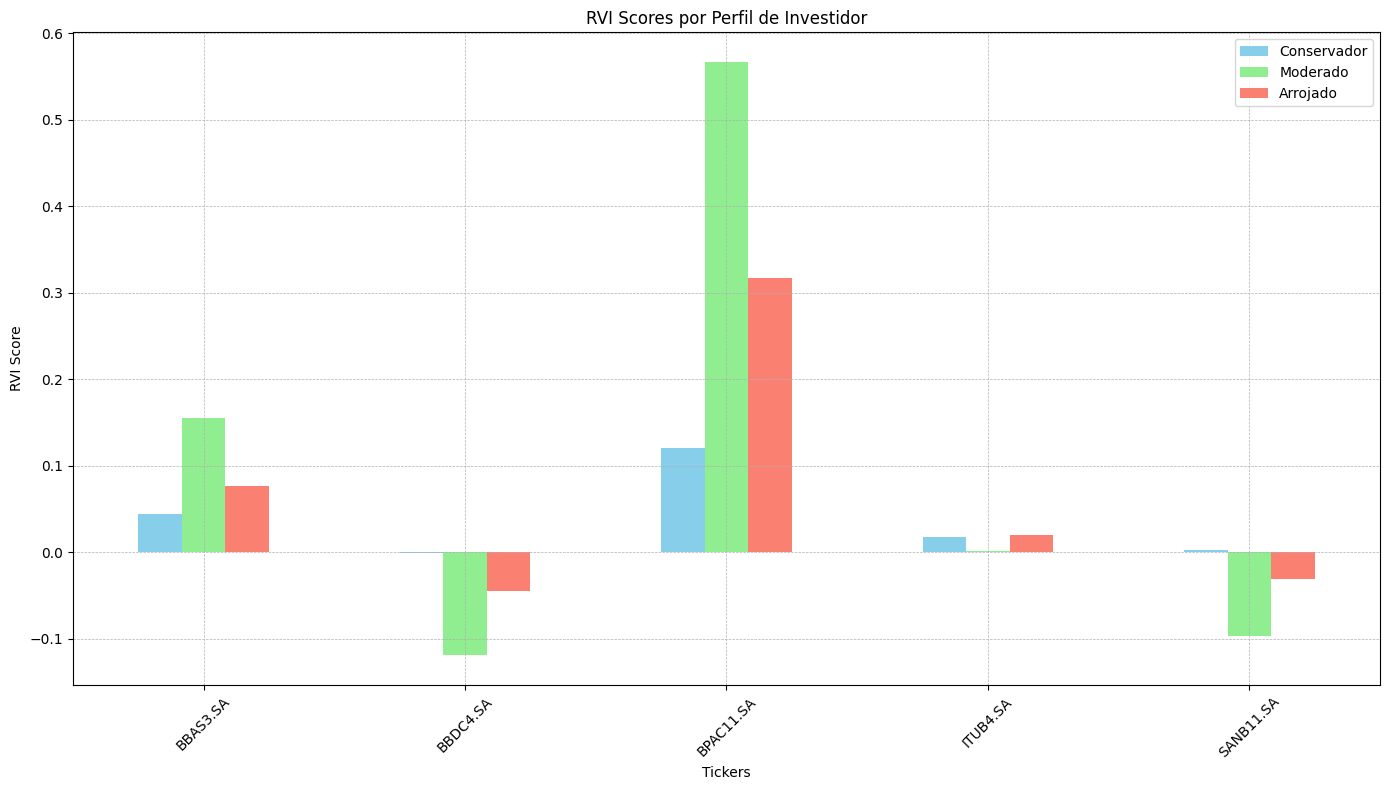

In [7]:
# Função para plotar um gráfico de barras colorido com grid
def plot_colorful_bars_with_grid(ticker_stats):
    profiles = ['rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
    colors = ['skyblue', 'lightgreen', 'salmon']
    ticker_stats.set_index('ticker')[profiles].plot(kind='bar', color=colors, figsize=(14, 8))
    plt.title('RVI Scores por Perfil de Investidor')
    plt.xlabel('Tickers')
    plt.ylabel('RVI Score')
    plt.legend(['Conservador', 'Moderado', 'Arrojado'])
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plotar o gráfico colorido com grid
plot_colorful_bars_with_grid(ticker_stats)

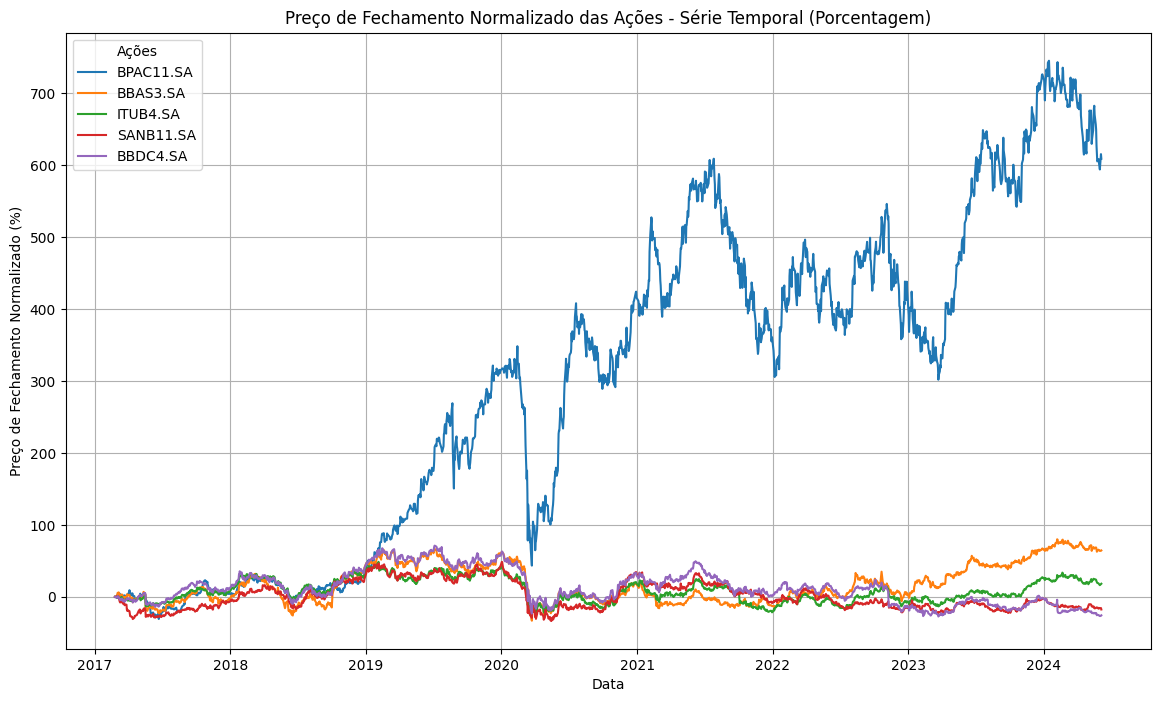

In [8]:
# Visualizar as 5 primeiras ações únicas no dataframe
top_tickers = df['ticker'].unique()[:5]

# Filtrar o dataframe para incluir apenas as 5 ações
filtered_df = df[df['ticker'].isin(top_tickers)]

# Normalizar os preços de fechamento para cada ação
normalized_df = filtered_df.copy()
for ticker in top_tickers:
    initial_value = normalized_df[normalized_df['ticker'] == ticker]['Close'].iloc[0]
    normalized_df.loc[normalized_df['ticker'] == ticker, 'Normalized_Close'] = 100 * (normalized_df[normalized_df['ticker'] == ticker]['Close'] / initial_value - 1)

# Plotar as séries temporais normalizadas para cada ticker
plt.figure(figsize=(14, 8))
for ticker in top_tickers:
    plt.plot(normalized_df[normalized_df['ticker'] == ticker]['Date'], normalized_df[normalized_df['ticker'] == ticker]['Normalized_Close'], label=ticker)

plt.title('Preço de Fechamento Normalizado das Ações - Série Temporal (Porcentagem)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Normalizado (%)')
plt.legend(title='Ações')
plt.grid(True)
plt.show()